In [10]:
import numpy as np
np.set_printoptions(suppress=True)

import networkx as nx
from sklearn.neighbors import KDTree

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10, 10)

In [2]:
def load_data(csvfile='colliders.csv'):
    return np.loadtxt(csvfile, delimiter=',', dtype=np.float64, skiprows=2)

In [3]:
from shapely.geometry import Polygon, Point
class Poly:

    def __init__(self, coords, height):
        self._polygon = Polygon(coords)
        self._height = height

    @property
    def height(self):
        return self._height

    @property
    def coords(self):
        return list(self._polygon.exterior.coords)[:-1]
    
    @property
    def area(self):
        return self._polygon.area

    @property
    def center(self):
        return (self._polygon.centroid.x, self._polygon.centroid.y)

    def contains(self, point):
        point = Point(point)
        return self._polygon.contains(point)

    def crosses(self, other):
        return self._polygon.crosses(other)


def extract_polygons(data):

    polygons = []
    for i in range(data.shape[0]):
        north, east, alt, d_north, d_east, d_alt = data[i, :]
        
        obstacle = [north - d_north, north + d_north, east - d_east, east + d_east]
        corners = [(obstacle[0], obstacle[2]), (obstacle[0], obstacle[3]), (obstacle[1], obstacle[3]), (obstacle[1], obstacle[2])]
        
        # TODO: Compute the height of the polygon
        height = alt + d_alt

        p = Poly(corners, height)
        polygons.append(p)

    return polygons

In [4]:
def sample_points(data, n_points=100, z_limit=10):
    centers = data[:, 0:3]
    sizes = data[:, 3:6]
    
    #radius_xyz = np.sqrt(np.sum(sizes**2, axis=1)).max()
    radius_xy = np.sqrt(np.sum(sizes[:,0:2]**2, axis=1)).max()

    max_x, max_y, max_z = np.max(centers + sizes, axis=0)
    min_x, min_y, min_z = np.min(centers - sizes, axis=0)

    # sample n_points
    points = np.random.uniform(low=[min_x, min_y, min_z],
                             high=[max_x, max_y, min(max_z, z_limit)],
                             size=(n_points,3))

    polygons = extract_polygons(data)
    tree = KDTree(centers[:,0:2], metric='euclidean')

    good_points = []
    for p in points:
        bad = False
        for n_idx in tree.query_radius([[p[0], p[1]]], r=radius_xy)[0]:
            if polygons[n_idx].contains(p):
                bad = True
                break
        if not bad:
            good_points.append(p)
            
    return np.array(good_points)

data = load_data()
points = sample_points(data, 300, z_limit=2)
len(points)

183

In [5]:
from shapely.geometry import Polygon, Point, LineString
def can_connect(n1, n2):
    l = LineString([n1, n2])
    for p in polygons:
        if p.crosses(l) and p.height >= min(n1[2], n2[2]):
            return False
    return True

def create_graph(points, bf=4, return_tree=False):
    """
    points: Nx3 array of sampled points 
    bf: branching factor
    """
    
    tree = KDTree(points)
    # get nearest neighbors of each point
    dist, nn_idx = tree.query(points, bf+1, return_distance=True)

    # drop the very nearest points (it's the query point itself)
    dist, nn_idx = dist[:,1:], nn_idx[:,1:] 
    
    g = nx.Graph()

    for point, nbrs_idx, dists in zip(points, nn_idx, dist):
        for idx, d in zip(nbrs_idx, dists):
            nbr = points[idx]
            g.add_edge(tuple(point), tuple(nbr), weight=d)
    
    if return_tree is True:
        return g, tree
    else:
        return g

In [6]:
data = load_data('colliders.csv')
np.random.seed(420)
points = sample_points(data, 300)
graph, kd_tree = create_graph(points, bf=5, return_tree=True)

len(points)

182

In [8]:
data = load_data('colliders.csv')
np.random.seed(421)
points = sample_points(data, 1000)
graph, kd_tree = create_graph(points, bf=6, return_tree=True)

start = (0,0,5)
goal = (300,300,5)

# find nodes closest to start and goal
(d1,d2),(s_idx,g_idx) = kd_tree.query([start, goal])

start_node = tuple(*points[s_idx])
goal_node = tuple(*points[g_idx])

assert start_node in graph
assert goal_node in graph
assert d1 < 50
assert d2 < 50

p = nx.algorithms.shortest_paths.astar.astar_path(graph, start_node, goal_node)

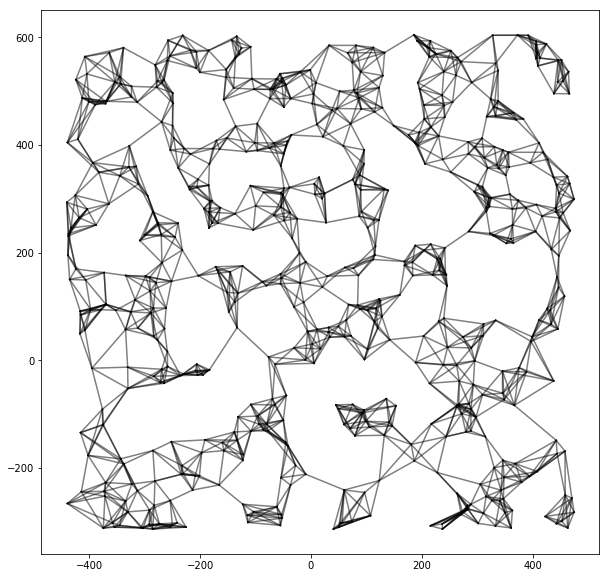

In [12]:
for (n1, n2) in graph.edges:
    plt.plot([n1[1], n2[1]], [n1[0], n2[0]], 'black' , alpha=0.5)